In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['cell_images']


The below cell imports all the necessary classes required in building the model and analysis

In [45]:
# Keras Imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


# Sci-kit learn imports
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [3]:
# Parameters

batch_size = 32
num_classes = 2
epochs = 50
data_augmentation = True

First, let us visualize the images of infected and uninfected cells.

In [13]:
# Path array of infected cell images
infected_cells=glob.glob("../input/cell_images/cell_images/Parasitized/*.png")
uninfected_cells=glob.glob("../input/cell_images/cell_images/Uninfected/*.png")

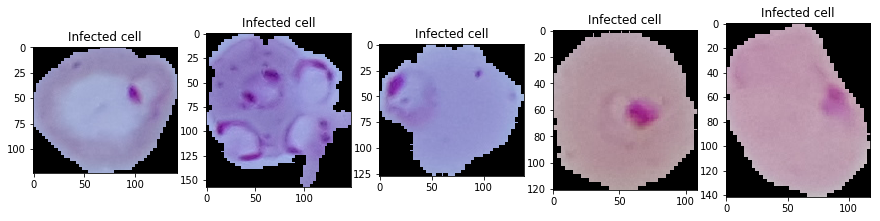

In [8]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(1,5,i)
    ran=np.random.randint(100)
    plt.imshow(cv2.imread(infected_cells[ran]))
    plt.title('Infected cell')

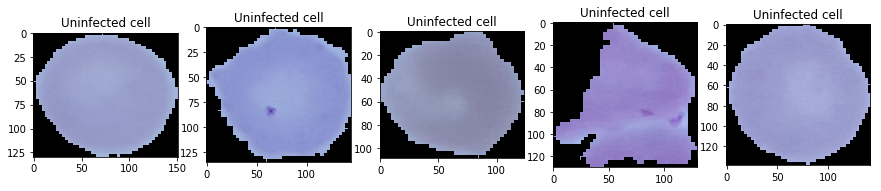

In [6]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(1,5,i)
    ran=np.random.randint(100)
    plt.imshow(cv2.imread(uninfected_cells[ran]))
    plt.title('Uninfected cell')

Since the data is in raw format, we convert it into rgb array and reshape it in the form of feature vector. Then depending on the image, we add an appropriate label to its correspnding index.

In [37]:
# Create feature and response matrix for the image data
image_arr=list()
label=list()

for i in infected_cells:
    img=cv2.imread(i)
    img_res=cv2.resize(img,(64,64))
    image_arr.append(img_res)
    label.append(1)

for j in uninfected_cells:
    img=cv2.imread(j)
    img_res=cv2.resize(img,(64,64))
    image_arr.append(img_res)
    label.append(0)

In [40]:
# List to Array Conversion and lengths
image_arr=np.array(image_arr)
label=np.array(label)
image_arr.shape, label.shape

((27558, 64, 64, 3), (27558,))

From the above images, we can clearly distinguish that the cells with red(or pink) color blobs are being categorized as infected cells. Let us divide the data into training and testing data


In [48]:
# Shuffling of data since all 1s' and 0s' have been appended together

image_arr, label = shuffle(image_arr, label, random_state=0)

# Train-Test split

X_train, X_test, y_train, y_test=train_test_split(image_arr,label,test_size=0.2, random_state=0)

27558


We must perform image augmentation on the existing images to make the neural network more versatile. In common words, we apply several transformation techniques like scaling, shearing, rotation etc. to the existing images. This causes the model to be trained in such a way that it can detect even the most uncommon of occurences.

In [50]:
# Image Augementation

## Generic Image Data Generator 
train_generator=ImageDataGenerator(rotation_range=20,width_shift_range=0.25,height_shift_range=0.25,
                             shear_range=0.2,zoom_range=0.3,horizontal_flip=True,vertical_flip=True,
                             rescale=1/255.)

test_generator=ImageDataGenerator(rescale=1/255.)

# Applying generators to training and testing images with additional parameters
train_gen=train_generator.flow(X_train,y_train,batch_size=32,shuffle=False)
test_tor=test_generator.flow(X_train,y_train,batch_size=1,shuffle=False)



Let us create our neural network. A neural network in general consists of Convolution, Pooling, Flatten and Dense layers. The function of each of the mentioned layers can be understood by going through the theory involved in building a CNN.

In [10]:
# Function to build a neural network

def CNN_neural():
    # Indicates that our model is built using Sequential layers
    model=Sequential()
    
    # First, we add multiples convolution layers to find patterns
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',input_shape=(64,64,3)))
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu'))
    
    # Next, we add Pooling layer to reduce the size and find the occurence of feature in the convolution set
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # We repeat the same to create a slightly complex model
    model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # To prevent overfitting
    model.add(Dropout(0.25))
    
    # Now we begin the construction of ANN with the above network output as input
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    
    return model
    

Now, we compile the above model with appropriate optimizers and metrics to build a final model

In [11]:
model=CNN_neural()
model.compile(loss=binary_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxP

We are done with preliminary steps and are now ready to fit the model to the augmented data.